# Predict TripAdvisor Rating

In this competition we're provided with:
- train and test datasets of 40,000 and 10,000 samples respectivly and 9 features except target feature;
- target feature is **Rating** - discrete number.
- model with hyperparameters that we're **not allowed** to change (**RandomForestRegressor**: {'bootstrap': **True**, 'criterion': '**mse**', 'max_features': '**auto**', 'n_estimators': 100});
- baseline that gives **MAE** = 0.212

**What has been done**:
1. New features:
    - restaurant type, area food, country food, spcialities were get from cuisine style feature
    - name of restaurant and its region were get from url
    - chain and chain_scale were get by grouping restaurants' names
    - lasts 2 reviews date delta and last review date delta with max date of review as well as positive and negative words scores were get from reviews feature
    - some normalized and scaled be city numerical features
    - some means and medians
    - polinomial features
    - dummy features
2. 27 tests of model with different features conbinations
3. **MAE** has been reduced to **0.198** and after rounding predict with pitch 0.5 to make continious number discrete - to **0.168** on validation data (**0.1726** on the submission)

- For data investigation results go to 'Bella K [SF TripAdvisor Rating] EDA+NaNs'
- For models testing results go to 'Bella K [SF TripAdvisor Rating] FE+Models'

# import

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [15]:
from matplotlib import rcParams
#%config InlineBackend.figure_format = 'svg' # graphs in svg look clearer
plt.style.use('ggplot')  # beautiful graphs
plt.rcParams['figure.figsize'] = (12, 4)  # figure size

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from datetime import date

In [16]:
# make our experiments reproducible
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime(date.today().strftime('%Y-%m-%d'))
CURRENT_DATE

Timestamp('2023-05-22 00:00:00')

In [17]:
# fix the version of the packages
!pip freeze > requirements.txt

# DATA

In [18]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

print('Size of the train dataset:', df_train.shape)
#print('Size of the test dataset:', df_test.shape)
#print('Size of the submission dataset:', sample_submission.shape, end='\n\n')

Size of the train dataset: (40000, 10)


In [19]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


# Model

In [20]:
df_train.Rating.unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.model_selection import cross_validate
#from sklearn.model_selection import cross_val_score

In [22]:
def get_X_y(df):
    train_data = df.copy()
    #test_data = df.query('sample == 0').drop(['sample'], axis=1)

    y = train_data.rating.values            
    X = train_data.drop(['rating'], axis=1)
    
    return X, y

    
    
def get_prediction(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred


    
def get_metrics_round(model, y_pred, X_train, y_train, X_test, y_test):
    
    # rounding predict with pitch 0.5
    y_pred_round = []
    for item in y_pred:
        y_pred_round.append(round(item/0.5)*0.5)
    y_pred_round_array = np.asarray(y_pred_round)
    
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_round_array)) # !!!!!
    
    # the coefficient of determination of the prediction - r2_score
    print('Train r2_score:', model.score(X_train, y_train))
    print('Test r2_score:', model.score(X_test, y_test), end='\n\n')
    
    print('Model parametrs:\n', model.get_params())
    
    plt.rcParams['figure.figsize'] = (10, 8)
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh', title='Feature importances')
    plt.show()
    
    
    
def modelizer_round(df):
    X, y = get_X_y(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

    model, y_pred = get_prediction(X_train, X_test, y_train)

    get_metrics_round(model, y_pred, X_train, y_train, X_test, y_test)
    
    return model, X, y



def plot_cv_metrics(cv_metrics):
    avg_r2_train, std_r2_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_r2_valid, std_r2_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] r2_score = {:.2f} +/- {:.2f}'.format(avg_r2_train, std_r2_train))
    print('[valid] r2_score = {:.2f} +/- {:.2f}'.format(avg_r2_valid, std_r2_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('r2_score', fontsize=15)
    plt.legend(fontsize=15)


# Preprocessing

In [23]:
# FUNCTIONS

import collections

# count the number of mentions of unique values and get those that come across more than 1 time
def collect_repeated_items(col):
    c = collections.Counter()
    for el in df_train[col].tolist():
        c[el]+=1
    print('Unique values:', len(c))
    
    new_c = {k: v for k, v in c.items() if v > 1}
    print('Values repeated more then one time:', len(new_c))
    
    c_list = list(new_c.keys())
    
    return c_list



import math

# divide all restaurants into conditional groups by frequency of occurrence
def get_param_scale(cell):
    for el in percentile_75_list:
        if cell < el+1:
            cell = el
            break
    
    return cell


# take the percentile as a criterion
def get_percentile(pc, df, col):
    percentile_list = []
    percentile = 0
    col_max = max(df[col])

    while math.ceil(col_max) > math.ceil(percentile):
        percentile = math.ceil(np.percentile(df.loc[(df[col]>percentile)][col], pc))
        percentile_list.append(percentile)
        
    return percentile_list



# make a dictionary of the Cuisine Style frequency taking into account a certain parameter
def cuisine_count_dict(cell):
    c = collections.Counter()
    for el in cell:
        if el is not np.nan:
            if type(el)==list:
                for x in el:
                    c[x]+=1
            else:
                c[el]+=1
    
    c = {k: v for k, v in sorted(c.items(), key=by_value, reverse=True)}
    return c


# sort the dictionary in descending order of quantity
def by_value(item):
    return item[1]


def find_item(cell):
    if item in cell:
        return 1
    return 0



# count the number of positive and negative words in the reviews
import re
import nltk
from nltk.corpus import stopwords

def get_words_list(cell):
    cell_text = ' '.join(cell)
    cell_text_new = re.sub(r'[.,?!:;()=-_\'\"]', '', cell_text)
    cell_words_list = cell_text_new.split(' ')
    cell_words_list = [w.strip() for w in cell_words_list if len(w) > 1 ]
    cell_words_list = [w.strip() for w in cell_words_list if w not in stopwords.words('english')]
    
    return cell_words_list


def get_positive_score(cell):
    cell_score = sum([1 for w in cell if w in pos_list])
    
    return cell_score


def get_negative_score(cell):
    cell_score = sum([1 for w in cell if w in neg_list])
    
    return cell_score



# in the case of chain==1, rest_type, area_food, country_food, specialties will be filled with mods by city and name
def get_mode(col):

    city_name_dict = {}
    for city in df_train.city.unique():
        city_name_dict.update({city: {'name': df_train.loc[(df_train['city']==city)&(df_train['chain']==1)&(df_train['name'].isna()==False)].groupby('name')[col].apply(lambda x: x.mode()).reset_index().to_dict('index')}})

    city_name_dict = {k: v['name'] for k, v in city_name_dict.items()}
    city_name_dict = {key: {v['name']: v[col] for k, v in city_name_dict[key].items()} for key, value in city_name_dict.items()}

    return city_name_dict
    # {'Paris': {'231_east_street': 'Fast Food', ...}}
    
    
# in case of chain==0 rest_type_count, area_food_court, country_food_count, specialities_count
# fill in median by city and price_range
def get_median(col):

    city_price_dict = {}
    for city in df_train.city.unique():
        city_price_dict.update({city: {'price_range': df_train.loc[(df_train['city']==city)&(df_train['chain']==0)&(df_train['name'].isna()==False)].groupby('price_range')[col].median().reset_index().to_dict('index')}})

    city_price_dict = {k: v['price_range'] for k, v in city_price_dict.items()}
    city_price_dict = {key: {v['price_range']: round(v[col], 0) for k, v in city_price_dict[key].items()} for key, value in city_price_dict.items()}

    return city_price_dict
    # 'Krakow': {1.0: 1.0, 2.5: 1.0, 4.0: 2.0}

    

from itertools import product

def get_stat_dict(df, cat, num, stat): # stat_list = ['mean', 'median', 'std', 'quant_25', 'quant_75']
    
    cat_num_dict = {}
    
    if stat=='mean':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].mean().reset_index().to_dict('index')}})
        
    elif stat=='median':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].median().reset_index().to_dict('index')}})
        
    elif stat=='std':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].std().reset_index().to_dict('index')}})
    
    elif stat=='quant_25':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].quantile(0.25).reset_index().to_dict('index')}})
        
    elif stat=='quant_75':
        for city in df.city.unique():
            cat_num_dict.update({city: {str(cat): df.loc[df['city']==city].groupby(cat)[num].quantile(0.75).reset_index().to_dict('index')}})
        
    cat_num_dict = {k: v[str(cat)] for k, v in cat_num_dict.items()}
    cat_num_dict = {key: {v[str(cat)]: round(v[str(num)], 2) for k, v in cat_num_dict[key].items()} for key, value in cat_num_dict.items()}
    
    
    return cat_num_dict



def get_data_columns(list_of_lists):
    columns_list = []
    for el in list_of_lists:
        columns_list.extend(el)
        
    return columns_list


def remove_elments(old_list, el_list):
    for el in el_list:
        old_list.remove(el)
        
    return old_list


def get_data_columns_dict(list_of_names):
    columns_list = []
    for name in list_of_names:
        for el in features_dict[name]:
            columns_list.extend([el])
            
    return columns_list


def features_dict_update(feature_list_name, new_feature):
    feature_list = features_dict[feature_list_name]
    feature_list.extend([new_feature])
    features_dict.update({feature_list_name: feature_list})


def check_columns(list_of_names):
    print('Data columns count:', len(list(df_train.columns)))
    print('not_relvant count:', len(features_dict['not_relvant']))
    
    for list_el in list_of_names:
        print(list_el, 'count:', len(features_dict[list_el]))
        
    print('Columns check:', len(list(df_train.columns))==(len(features_dict['not_relvant'])+len(get_data_columns_dict(list_of_names))))

    


In [24]:
# DICT with LISTS

lists_dict = {'rest_type_list': ['Bar', 'Pub', 'Cafe', 'Fast Food', 'Steakhouse', 'Street Food', 'Gastropub',
                  'Wine Bar', 'Barbecue', 'Seafood', 'Pizza', 'Soups', 'Sushi', 'Diner',
                  'Grill', 'Brew Pub', 'Contemporary', 'Fusion', 'Delicatessen'
                 ],
              'area_food_list': ['Mediterranean', 'European', 'Scandinavian', 'Eastern European', 
                  'Central European', 'African', 'Middle Eastern', 'International', 'Arabic', 
                  'Southwestern', 'Asian', 'Central American', 'South American', 'Persian', 
                  'Latin', 'Balti', 'Caribbean', 'Minority Chinese', 'Cajun & Creole', 
                  'Native American', 'Yunnan', 'Xinjiang', 'Central Asian', 'Caucasian'
                 ],
              'country_food_list': ['Italian', 'French', 'Portuguese', 'Greek', 'Czech', 'British', 'Spanish',
                     'Norwegian', 'Moroccan', 'Indian', 'Thai', 'Dutch', 'Welsh', 'American',
                     'Scottish', 'Hungarian', 'Peruvian', 'Irish', 'Polish', 'Vietnamese',
                     'Lebanese', 'Turkish', 'Japanese', 'Austrian', 'Chinese', 'Danish',
                     'Korean', 'German', 'Swiss', 'Swedish', 'Australian', 'Mexican', 'Belgian',
                     'Argentinean', 'Tunisian', 'Russian', 'Nepali', 'Bangladeshi', 'Colombian',
                     'Sri Lankan', 'Pakistani', 'Israeli', 'Brazilian', 'Ethiopian', 
                     'Taiwanese', 'Indonesian', 'Malaysian', 'Venezuelan', 'Armenian', 
                     'Slovenian', 'Jamaican', 'Ecuadorean', 'Chilean', 'Hawaiian', 'Croatian',
                     'Cambodian', 'Afghani', 'Tibetan', 'Romanian', 'Mongolian', 'Singaporean',
                     'Filipino', 'Cuban', 'Canadian', 'Egyptian', 'Azerbaijani', 'Georgian',
                     'New Zealand', 'Ukrainian', 'Albanian', 'Polynesian', 'Uzbek',
                     'Salvadoran', 'Burmese', 'Fujian', 'Latvian'
                    ],
              'spcialities_list': ['Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options', 'Halal',
                    'Healthy', 'Kosher'],
              'pos_list': ['excellend', 'wonderland', 'profect', 'outstand', 'excellentservice', 'yummmmmmmmmmmmmmmmmmmmmmmmmmmmm', 'besttt', 
 'awseome', 'tastyyyyy', 'fastest', 'reccommend', 'recomend', 'wonderland', 'reccomend', 'excelente', 'tidy', 'awsome',
 'awesome', 'finest', 'greatest', 'friendliest', 'tastiest', 'cheapest', 'freshest', 'yummiest', 'coolest', 
 'loveliest', 'quickest', 'lovelyest', 'fondest', 'juciest', 'sweetest', 'amazing', 'charming', 'welcoming', 
 'relaxing', 'stunning', 'exciting', 'breathtaking', 'loving', 'enjoying', 'astonishing', 'amaizing', 'fascinating',
'greeting', 'enchanting', 'recommending', 'impressing', 'understanding', 'amzing', 'outsanding', 'blessing', 'amusing',
'serviceamazing', 'supporting', 'ahmazing', 'ourstanding', 'captivating', 'aaaaamazing', 'amamzing', 'amassamazing',
'outshining', 'scintillating', 'exhilarating', 'appetising', 'mazing', 'amazzzzzing', 'amaaaaaaazing', 'placeamazing',
'amaaazing', 'amanzing', 'fingerlicking', 'mindblowing', 'momazing', 'appetizing', 'outstanging', 'wordamazing', 
'amazingamazing', 'enjoyed', 'excellen', 'serviceminded', 'personified', 'yummy', 'good', 'great', 'nice', 'excellent',
'delicious', 'tasty', 'fantastic', 'perfect', 'cheap', 'ok', 'pleasant', 'super', 'cool', 'fabulous', 'healthy', 'fine',
'brilliant', 'outstanding', 'affordable' 'cute', 'enjoyable', 'wow', 'delightful', 'unique', 'incredible' 'comfortable',
'delight', 'inexpensive', 'romantic', 'cheerful', 'proper', 'stylish', 'helpful', 'gorgeous', 'generous', 'intimate',
'attentive', 'chill', 'elegant', 'gourmet', 'impressed', 'excelent', 'ideal', 'fancy', 'exquisite', 'memorable', 
 'spectacular', 'tasteful', 'terrific', 'peaceful', 'extraordinary', 'exellent', 'spacious', 'wonderfull', 'magical',
'worthy', 'adorable', 'upscale', 'flavorful', 'marvellous', 'delicous', 'unbeatable', 'recommendable', 'gastronomic',
'flavourful', 'magnificent', 'scrumptious', 'impeccable', 'friendl', 'deliciousness', 'marvelous', 'tremendous', 
 'entertaining', 'fantastico', 'lovey', 'faultless', 'freshness', 'excellant', 'yummi', 'worthwhile', 'delectable',
'fantasic', 'confortable', 'execellent', 'energetic', 'tastefull', 'unmissable', 'hospitable', '5-star', 'precious',
'gentle', 'wondeful', 'exelent', 'delcious', 'fantastique', 'delucious', 'exclusive', 'fanastic', 'faithful', 'gracious',
'accurate', 'luxurious', 'superior', 'phantastic', 'goody', 'a-mazing', 'majestic', 'recomendable', 'resonable',
'magnificant', 'magnifico', 'bellisimo', 'gourm', 'unexpensive', 'significant', 'must-go-to', 'exzellent', 'wooow',
'appetite', 'shambolic', 'delicatessan', 'good-value', 'roomy', 'healthful', 'unlimited', 'palatable', 'wowww', 
 'goooood', 'delicious', 'quickeasy', '***amazing***', 'rome-antic', 'fresh', 'fast', 'incredible/', 'especi', 'tastyy',
'place-to-be', 'fabulous', 'gastromique', 'lovely-', 'likeable', 'comprehensive', 'representable', 'exceptionnal',
'testy', 'harmonious', 'grateful', 'firey', 'yummmmm', 'under-appreciated', 'splendiferous', 'superrrrrrrr', 'enjoyabl',
'great', '-fantastic', 'wondersful', 'über-delicious', 'extroardinary', 'woooww', 'wonderdful', 'friendlygood', 'tasty',
'absolutelypositivethe', 'amazing-', 'gastrochic', 'woww', 'flavorfull', 'amazinggggg', 'delicuous', 'peacfull', 
 '-reasonable', 'to-die-for', 'awessome', 'fantastic', 'excelletn', 'tastyyy', 'wunderfull', 'irresistible', 'woooo',
'well-prepared', 'curryexcelent', 'tasty-', 'excellenct', 'ethic', 'unicorn', 'teasty', 'inspirational', 'wondrful',
'remarcable', 'heathy', 'good', 'unedible', 'nice', 'reasonnable', 'friendlyhelpful', 'marevllous', 'deeeelicious', 
'wonderwull', 'de-li-ci-ous', 'excellento', 'excellet', 'enjoyed-tasty', 'delicious', 'fantasctic', 'competen', 'goodb',
'okey', 'excellent', 'funtastic', 'gret', 'pleasurable', 'oksome', 'well-above-average', 'recommandable', 'ecxcellent',
'good-tasting', 'tasty', 'delighthful', 'responsible', 'soul-warming', 'hospitali', 'compliment', 'surpricegreat', 
 'orgasm', 'top5', 'deliciousmeql', 'fantastissimo', 'enjoyable-', 'tasteunforgettable', 'eccccccezionale', 'goodie',
'aweaome', 'fairtrade', 'gastronomical', 'foodstaff-wow', 'fanatastic', 'presentable', 'date-worthy', 'okish', 
 'a-m-a-z-i-n-g', 'fenomenal', 'delighful', '-healthy', 'good', 'dishi', 'delishious', 'deligious', 'mind-blowing',
'peeeeeerfect', 'excellent-ish', 'greatt', 'execerlent', 'good-priced', 'amazng', 'delicious', 'excellent', 'profesional',
'wobderful', 'enjoyablel', 'super-excellent', 'rasonable', 'price-attractive', 'comfortable/authentic', 'razonable',
'goode', 'buonísimo', 'staff-great', 'delecious', 'foodexcellent', 'delicious', 'good', 'foodwonderful', 'work-friendly',
'kid-friendly', 'fantasstic', 'agood', 'prfect', 'positiv', 'inexpenssive', 'personale', 'best', 'friendly', 'lovely',
'fun', 'yummy', 'reasonably', 'perfectly', 'pleasantly', 'amazingly', 'incredibly', 'nicest', 'quickly', 'deliciously',
'exceptionally', 'frendly', 'wonderfully', 'warmly', 'delightfully', 'fantastically', 'fabulously', 'brilliantly', 
 'yummmmmm', 'gastronomically', 'comfortably', 'spotlessly', 'elegantly', 'tastefully', 'neatly', 'gently', 'oke', 
 'stunningly', 'frindly', 'amazlingly', 'lovingly', 'nice', 'freiendly', 'helpfulfriendly', 'exquisitly', 'outstandingly',
'loverly', 'excitingly', 'cheerfully', 'merely', 'friendlly', 'dog-friendly', 'super-friendl', 'lovelly', 'imaginatively',
'pleasently', 'stupendously', 'oki', 'privately', 'superfriendly', 'pleasurably', 'ĺovely', 'finger-lickingly', 'friéndly',
'lovvely', 'wondefully', 'kindly', 'sophisticated', 'welcomed', 'personalized', 'excited', 'delighted', 'skilled', 
 'talented', 'openminded', 'goodfood', 'mesmerised', 'sofisticated', 'fingerlickin', 'lovelier'],
              'neg_list': ['expencieve', 'rude', 'dissappointment', 'robbery', 'rudest', 'pain', 'grumpy', 'racist', 'worst', 'dishonest', 
 'slowest', 'poorest', 'weakest', 'woest', 'crappiest', 'worest', 'ugliest', 'wettest', 'waiting', 'disgusting',
'boring', 'lacking', 'watering', 'shocking', 'underwhelming', 'cracking', 'buzzing', 'bustling', 'disapointing',
'misleading', 'dissapointing', 'confusing', 'depressing', 'annoying', 'poisoning', 'unwelcoming', 'discusting',
'unsatisfying', 'embarrassing', 'unprepossessing', 'wasting', 'uncaring', 'melting', 'suckling', 'obliging', 
'frustrating', 'uninteresting', 'freaking', 'smelling', 'overcharging', 'revolting', 'unconvincing', 'disapponiting',
'desappointing', 'dissappinting', 'overdoing', 'diasppointing', 'disppointing', 'disapoointing', 'missleading',
'appauling', 'disappearing', 'madding', 'unexciting', 'promissing', 'hustling', 'thumping', 'buzzling', 'mourning',
'raving', 'conflicting', 'lingering', 'poisening', 'infuriating', 'pining', 'overpricing', 'deteriorating', 'tiring',
'disconcerting', 'thrilling', 'disappoing', 'crackling', 'terrifying', 'sprawling', 'pretending', 'wasdisappointing',
'rushing', 'sneaking', 'isappointing', 'charging', 'milking', 'disturbing', 'overpriced', 'disapointed', 'microwaved',
'overprized', 'disinterested', 'stolen', 'ignored', 'destroyed', 'bullied', 'worn', 'enforced', 'buggered', 
 'otheroverrated', 'interrupted', 'oiled', 'deceived', 'killed', 'naught', 'bad', 'expensive', 'poor', 'terrible',
'avoid', 'awful', 'horrible', 'disappointed', 'trap', 'wrong', 'tasteless', 'loud', 'dreadful', 'odd', 'arrogant',
'unpleasant', 'rubbish', 'appalling', 'unprofessional', 'sick', 'horrendous', 'miserable', 'nasty', 'aggressive',
'expensiv', 'dangerous', 'over-priced', 'hectic', 'questionable', 'impolite', 'garlic', 'uncomfortable', 'disappoint',
'messy', 'unacceptable', 'disorganized', 'expensi', 'uninspiring', 'negative', 'rough', 'pathetic', 'fake', 'unhelpful',
'indifferent', 'difficult', 'disgraceful', 'aweful', 'costly', 'inadequate', 'filthy', 'undercooked', 'ridiculous',
'disrespectful', 'underwhelmed', 'horrid', 'desperate', 'fatty', 'unhappy', 'soulless', 'outrageous', 'disapointment',
'unimpressive', 'rouge', 'unremarkable', 'avoidable', 'stupid', 'shameful', 'unwelcome', 'expencive', 'deceptive',
'impersonal', 'unimaginative', 'unreliable', 'unsatisfactory', 'hideous', 'unfrie', 'over-cooked', 'inattentive',
'incomplete', 'rubish', 'upset', 'no-go', 'moldy', 'tragic', 'food/poor', 'funprofessional', 'looooong', 'foodweird',
'disastrous', 'unhealthy', 'unprofessi', 'buzzed', 'steamy', 'oversold', 'sleepy', 'poorish', 'disasterous', 
 'not-deserted', 'no-personality', 'conflictual', 'incoherent', 'unnecessary', 'tricky', 'incomprehensible', 
 'over-rated', 'unappealing', 'over-ambitious', 'dismissive', 'impresionante', 'обман/cheat', 'unattractive', 
 'non-sense', 'unacceptabl', 'apathetic', 'questionnable', 'untasty', 'fraudulent', 'useless', 'saltyyyyyyyy', 
 'disappointingterrible', 'fraude', 'unimpressible', 'place-nothing', 'insignificant', 'all-microwaved', 'aggresive',
'obligatory', 'terriblenomuch', 'disrespect', 'worn-out', 'foodquestionable', 'uunisaari', 'unhygenic', 'understaffe',
'uninspired', 'trashy', 'misogynistic', 'tertible', 'doubtful', 'indefinite', 'howful', 'unspectacular', 'sloooow', 
 'untasetiness', 'anti-customer', 'superficial', 'assertive', 'froid', 'misguide', 'not-great', 'ugliestoldest', 
 'ambiguous', 'unpleasent', 'frugal', 'uninportant', 'taseteless', 'awful-', 'unprofessionnal', 'unpolite', 'unreasonable',
'lamentable', 'slowl', 'staffexpensive', 'unaccomodating', 'orderavoidavoidavoid', 'stereotype', 'hit-and-miss', 
 'foxy', 'naughty', 'inconvenient', 'disappointing-', 'snobb', 'must-avoid', 'slurpilicious', 'ridicolous', 'dismal',
'undeserved', 'unintereste', 'underperforming', 'clumsy', 'reservationbut', 'unsatisfied', 'catastrophic', 'deplorable',
'pitiful', 'unsophisticated', 'thrash', 'scam', 'fails', 'mistake', 'ignorant', 'never', 'unfriendly', 'noisy', 'sadly',
'unfortunately', 'poorly', 'terribly', 'shockingly', 'badly', 'ridiculously' 'utterly', 'awfull', 'hardly', 'ugly', 
 'barely', 'madness', 'microscopic', 'horribly', 'unacceptably', 'silly', 'effortless', 'awfully', 'tremendously', 
 'absurdly', 'nosily', 'loudly', 'unfortunetly', 'nightmarishly', 'chaotically','devastatingly', 'unreasonably', 'purely',
'ludicrously', 'dangerously', 'unintentionally', 'insufficiently', 'unfirendly', 'inexplicably', 'painfully', 
 'disgustingly', 'smelly', 'desperately', 'ridicolously', 'apology', 'frustratingly', 'rudely', 'inordinately', 'pitty',
'disappointingly', 'diningunfortunately', 'annoyingly', 'horrifically', 'deviously', 'overrated', 'overcharged', 'ruined',
'overcooked', 'bored', 'wicked', 'disorganised', 'overcrowded', 'shocked', 'unorganized', 'cheated', 'insulted', 'spoiled',
 'disgusted', 'failed', 'robbed', 'scamed', 'humiliated', 'dismanered', 'yelled', 'annoyed', 'unimpressed', 'overestimated',
'dispointed', 'disapponted', 'spolied', 'underestimated', 'inexprienced', 'fooduncooked', 'poisoned', 'ashamed', 'worse']
             }

In [25]:
import json

with open('/kaggle/working/lists_dict.json', 'w') as outfile:
    json.dump(lists_dict, outfile)

In [26]:
#def preproc_train_data(df_input):
    
# DATA
    #df_train = df_input.copy()
    
print('Data processing started')

#df_train['sample'] = 1 # mark the train
df_train.columns = [x.lower().replace(' ', '_') for x in df_train.columns]

# the structure of the list, but the data type is a string
# turn it into a list
df_train['cuisine_style'] = df_train['cuisine_style'].dropna().apply(lambda x: x[2:-2].split("', '"))
# count the number of kitchens
df_train['cuisine_style_count'] = df_train['cuisine_style'].dropna().apply(lambda x: len(x))

df_train['price_range'] = df_train['price_range'].dropna().apply(lambda x: 1.0 if x=='$' else (2.5 if x=='$$ - $$$' else(4.0 if x=='$$$$' else x)))


city_count = df_train['city'].value_counts()
df_train['city_count'] = df_train['city'].dropna().apply(lambda x: city_count[x] if x in city_count.index else np.nan)


# get the data about the name of the restaurant (or chain?), the region and some other g-code from URL_TA
df_train['name'] = df_train['url_ta'].dropna().apply(lambda x: x.split('-')[4].replace('.html', ''))
df_train['region'] = df_train['url_ta'].dropna().apply(lambda x: x.split('-')[5].replace('.html', '') if len(x.split('-'))>5 else x.split('-')[4].replace('.html', ''))
df_train['g_code'] = df_train['url_ta'].dropna().apply(lambda x: x.split('-')[1])
# in some cases, there is no indication of the name, then the region is pulled up - let's fix it
df_train.iloc[df_train.loc[df_train['name'] == df_train['region']].index.tolist(), df_train.columns.tolist().index('name')] = np.nan
df_train['name'] = df_train['name'].dropna().apply(lambda x: x.lower())
df_train['region'] = df_train['region'].dropna().apply(lambda x: x.lower())


name_count = df_train.loc[(df_train['name'].isna()==False)]['name'].value_counts()
df_train['name_count'] = df_train['name'].apply(lambda x: name_count[x] if x in name_count.index else 1)

df_train['chain'] = df_train['name_count'].dropna().apply(lambda x: 0 if x==1 else 1)
# take 75 percentile as a criterion
percentile_75_list = get_percentile(75, df_train, 'name_count') # chain_scale
df_train['chain_scale'] = df_train['name_count'].dropna().apply(get_param_scale)


gcode_count = df_train['g_code'].value_counts()
df_train['gcode_count'] = df_train['g_code'].dropna().apply(lambda x: gcode_count[x] if x in gcode_count.index else np.nan)


# the structure of the lists in the list (review and dates), but the data type is a string
# turning empty lists into nan and strings into lists
df_train['reviews'] = df_train['reviews'].dropna().apply(lambda x: np.nan if x == '[[], []]' else x[2:-2].split("], ["))

# at the same time, we separate the review and turn the data into lists
df_train['reviews_text'] = df_train['reviews'].dropna().apply(lambda x: x[0][1:-1].split("', '"))

# separate the dates from the review and turn the data into lists
df_train['reviews_date'] = df_train['reviews'].dropna().apply(lambda x: x[1][1:-1].split("', '"))
# turning strings into dates
df_train['reviews_date'] = df_train['reviews_date'].dropna().apply(lambda x: [pd.to_datetime(i) for i in x])
df_train['reviews_date_last'] = df_train['reviews_date'].dropna().apply(lambda x: max(x))

reviews_date_max = max(df_train['reviews_date_last'].dropna().tolist())
df_train['reviews_date_delta'] = df_train['reviews_date'].dropna().apply(lambda x: (max(x) - min(x)).days)
df_train['reviews_date_delta_max'] = df_train['reviews_date'].dropna().apply(lambda x: (reviews_date_max - max(x)).days)


# divide cuisine_style
df_train['rest_type'] = df_train['cuisine_style'].dropna().apply(lambda x: [st for st in lists_dict['rest_type_list'] if st in x])
df_train['rest_type_count'] = df_train['rest_type'].dropna().apply(lambda x: len(x))
df_train['rest_type'] = df_train['rest_type'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

df_train['area_food'] = df_train['cuisine_style'].dropna().apply(lambda x: [st for st in lists_dict['area_food_list'] if st in x])
df_train['area_food_count'] = df_train['area_food'].dropna().apply(lambda x: len(x))
df_train['area_food'] = df_train['area_food'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

df_train['country_food'] = df_train['cuisine_style'].dropna().apply(lambda x: [st for st in lists_dict['country_food_list'] if st in x])
df_train['country_food_count'] = df_train['country_food'].dropna().apply(lambda x: len(x))
df_train['country_food'] = df_train['country_food'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)

df_train['spcialities'] = df_train['cuisine_style'].dropna().apply(lambda x: [st for st in lists_dict['spcialities_list'] if st in x])
df_train['spcialities_count'] = df_train['spcialities'].dropna().apply(lambda x: len(x))
df_train['spcialities'] = df_train['spcialities'].dropna().apply(lambda x: ', '.join(x) if len(x)>0 else np.nan)
    
    
    
# NaNs
    
print('NaNs processing started')

# price_range

def round_to_closest(number, lst=[1.0, 2.5, 4.0]):
    return min(lst, key=lambda x: abs(x - number))

price_range_dict = {}
for city in df_train.city.unique():
    price_range_dict.update({city: {'chain_scale': df_train.loc[(df_train['city']==city)].groupby('chain_scale')['price_range'].mean().reset_index().to_dict('index')}})
        
price_range_dict = {k: v['chain_scale'] for k, v in price_range_dict.items()}
price_range_dict = {key: {v['chain_scale']: round_to_closest(v['price_range']) if math.isnan(v['price_range'])==False else np.nan for k, v in price_range_dict[key].items()} for key, value in price_range_dict.items()}

df_train['price_range_old'] = df_train['price_range']
df_train['price_range'] = df_train.apply(lambda x: price_range_dict[x['city']][x['chain_scale']] if math.isnan(x['price_range_old'])==True else x['price_range'], axis=1)
df_train['price_range'] = df_train['price_range'].fillna(2.5)


# number_of_reviews

num_rev_cuisine_dict = {}
for city in df_train.city.unique():
    num_rev_cuisine_dict.update({city: {'cuisine_style_count': df_train.loc[(df_train['city']==city)&(df_train['cuisine_style_count'].isna()==False)].groupby('cuisine_style_count')['number_of_reviews'].median().reset_index().to_dict('index')}})
        
num_rev_cuisine_dict = {k: v['cuisine_style_count'] for k, v in num_rev_cuisine_dict.items()}
num_rev_cuisine_dict = {key: {v['cuisine_style_count']: v['number_of_reviews'] if math.isnan(v['number_of_reviews'])==False else np.nan for k, v in num_rev_cuisine_dict[key].items()} for key, value in num_rev_cuisine_dict.items()}


num_rev_price_dict = {}
for city in df_train.city.unique():
    num_rev_price_dict.update({city: {'price_range': df_train.loc[(df_train['city']==city)].groupby('price_range')['number_of_reviews'].median().reset_index().to_dict('index')}})
        
num_rev_price_dict = {k: v['price_range'] for k, v in num_rev_price_dict.items()}
num_rev_price_dict = {key: {v['price_range']: v['number_of_reviews'] if math.isnan(v['number_of_reviews'])==False else np.nan for k, v in num_rev_price_dict[key].items()} for key, value in num_rev_price_dict.items()}


df_train['number_of_reviews_old'] = df_train['number_of_reviews']

df_train['number_of_reviews'] = df_train.apply(lambda x: num_rev_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['number_of_reviews_old'])==True and math.isnan(x['cuisine_style_count'])==False else x['number_of_reviews'], axis=1)
df_train['number_of_reviews'] = df_train.apply(lambda x: num_rev_price_dict[x['city']][x['price_range']] if math.isnan(x['number_of_reviews'])==True else x['number_of_reviews'], axis=1)



# cuisine_style

# instead of name_count, let's count name_city_count
city_name_dict = {}
for city in df_train.city.unique():
    city_name_dict.update({city: {'name': df_train.loc[(df_train['city']==city)&(df_train['name'].isna()==False)].groupby('name')['id_ta'].count().reset_index().to_dict('index')}})

city_name_dict = {k: v['name'] for k, v in city_name_dict.items()}
city_name_dict = {key: {v['name']: v['id_ta'] if math.isnan(v['id_ta'])==False else np.nan for k, v in city_name_dict[key].items()} for key, value in city_name_dict.items()}
# {'Paris': {015_gang_nam': 1}, ...}

df_train['name_city_count'] = df_train.apply(lambda x: city_name_dict[x['city']][x['name']] if x['name'] in list(city_name_dict[x['city']].keys()) else 1, axis=1)
df_train = df_train.drop('name_count', axis=1)


df_train['rest_type_old'] = df_train['rest_type']
df_train['area_food_old'] = df_train['area_food']
df_train['country_food_old'] = df_train['country_food']
df_train['spcialities_old'] = df_train['spcialities']

# in the case of chain==1 rest_type, area_food, country_food, specialties fill in with modes by city and name
city_name_dict = get_mode('rest_type')
df_train['rest_type'] = df_train.apply(lambda x: city_name_dict[x['city']][x['name']] if x['name'] in list(city_name_dict[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['rest_type'], axis=1)

city_name_dict = get_mode('area_food')
df_train['area_food'] = df_train.apply(lambda x: city_name_dict[x['city']][x['name']] if x['name'] in list(city_name_dict[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['area_food'], axis=1)

city_name_dict = get_mode('country_food')
df_train['country_food'] = df_train.apply(lambda x: city_name_dict[x['city']][x['name']] if x['name'] in list(city_name_dict[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['country_food'], axis=1)

city_name_dict = get_mode('spcialities')
df_train['spcialities'] = df_train.apply(lambda x: city_name_dict[x['city']][x['name']] if x['name'] in list(city_name_dict[x['city']].keys()) and math.isnan(x['cuisine_style_count'])==True else x['spcialities'], axis=1)

# recalculate all ..._count
df_train['rest_type_count'] = df_train['rest_type'].dropna().apply(lambda x: len(x.split(', ')))
df_train['area_food_count'] = df_train['area_food'].dropna().apply(lambda x: len(x.split(', ')))
df_train['country_food_count'] = df_train['country_food'].dropna().apply(lambda x: len(x.split(', ')))
df_train['spcialities_count'] = df_train['spcialities'].dropna().apply(lambda x: len(x.split(', ')))

# in the case of chain==0 cuisine_style_count, rest_type_count, area_food_count, country_food_count, spcialities_count, 
# fill in with median by city and price_range
city_price_dict = get_median('rest_type_count')
df_train['rest_type_count'] = df_train.apply(lambda x: city_price_dict[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['rest_type_count'], axis=1)

city_price_dict = get_median('area_food_count')
df_train['area_food_count'] = df_train.apply(lambda x: city_price_dict[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['area_food_count'], axis=1)

city_price_dict = get_median('country_food_count')
df_train['country_food_count'] = df_train.apply(lambda x: city_price_dict[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['country_food_count'], axis=1)

city_price_dict = get_median('spcialities_count')
df_train['spcialities_count'] = df_train.apply(lambda x: city_price_dict[x['city']][x['price_range']] if math.isnan(x['cuisine_style_count'])==True else x['spcialities_count'], axis=1)

# fill remain NaNs with 0 to recalculate cuisine_style_count
df_train['rest_type_count'] = df_train['rest_type_count'].fillna(0)
df_train['area_food_count'] = df_train['area_food_count'].fillna(0)
df_train['country_food_count'] = df_train['country_food_count'].fillna(0)
df_train['spcialities_count'] = df_train['spcialities_count'].fillna(0)

df_train['cuisine_style_count'] = df_train.apply(lambda x: x['rest_type_count']+x['area_food_count']+x['country_food_count']+x['spcialities_count'], axis=1)


# reviews_date_delta & reviews_date_delta_max
# We will fill in the gaps not in dates, but in intervals
rev_delta_cuisine_dict = {}
for city in df_train.city.unique():
    rev_delta_cuisine_dict.update({city: {'cuisine_style_count': df_train.loc[(df_train['city']==city)].groupby('cuisine_style_count')['reviews_date_delta'].median().reset_index().to_dict('index')}})
        
rev_delta_cuisine_dict = {k: v['cuisine_style_count'] for k, v in rev_delta_cuisine_dict.items()}
rev_delta_cuisine_dict = {key: {v['cuisine_style_count']: v['reviews_date_delta'] for k, v in rev_delta_cuisine_dict[key].items()} for key, value in rev_delta_cuisine_dict.items()}


rev_delta_max_cuisine_dict = {}
for city in df_train.city.unique():
    rev_delta_max_cuisine_dict.update({city: {'cuisine_style_count': df_train.loc[(df_train['city']==city)].groupby('cuisine_style_count')['reviews_date_delta_max'].median().reset_index().to_dict('index')}})
        
rev_delta_max_cuisine_dict = {k: v['cuisine_style_count'] for k, v in rev_delta_max_cuisine_dict.items()}
rev_delta_max_cuisine_dict = {key: {v['cuisine_style_count']: v['reviews_date_delta_max'] for k, v in rev_delta_max_cuisine_dict[key].items()} for key, value in rev_delta_max_cuisine_dict.items()}


df_train['reviews_date_delta_old'] = df_train['reviews_date_delta']
df_train['reviews_date_delta_max_old'] = df_train['reviews_date_delta_max']

df_train['reviews_date_delta'] = df_train.apply(lambda x: rev_delta_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['reviews_date_delta_old'])==True else x['reviews_date_delta'], axis=1)
df_train['reviews_date_delta_max'] = df_train.apply(lambda x: rev_delta_max_cuisine_dict[x['city']][x['cuisine_style_count']] if math.isnan(x['reviews_date_delta_max_old'])==True else x['reviews_date_delta_max'], axis=1)
    
    
    
# FEATURE ENGINEERING
    
print('Feature processing started')

# datasets' dividing
df_train['cuisine_style_count_old'] = df_train['cuisine_style'].dropna().apply(lambda x: len(x))
df_train['rest_type_count_old'] = df_train['rest_type_old'].dropna().apply(lambda x: len(x.split(', ')))
df_train['area_food_count_old'] = df_train['area_food_old'].dropna().apply(lambda x: len(x.split(', ')))
df_train['country_food_count_old'] = df_train['country_food_old'].dropna().apply(lambda x: len(x.split(', ')))
df_train['spcialities_count_old'] = df_train['spcialities_old'].dropna().apply(lambda x: len(x.split(', ')))


features_dict = {'common_features': ['rating', 'city', 'cuisine_style', 'ranking', 'city_count'],
                 'old_features': ['price_range_old', 'number_of_reviews_old', 'cuisine_style_count_old'],
                 'new_features': ['price_range', 'number_of_reviews', 'cuisine_style_count'],
                 'add_com_features': ['chain', 'chain_scale', 'name_city_count'],
                 'add_old_features': ['rest_type_old', 'area_food_old', 'country_food_old', 'spcialities_old',
                                      'rest_type_count_old', 'area_food_count_old', 'country_food_count_old', 'spcialities_count_old',
                                      'reviews_date_delta_old', 'reviews_date_delta_max_old'
                                     ],
                 'add_new_features': ['rest_type', 'area_food', 'country_food', 'spcialities',
                                       'rest_type_count', 'area_food_count', 'country_food_count', 'spcialities_count', 
                                       'reviews_date_delta', 'reviews_date_delta_max'
                                     ],
                 'not_relvant': ['restaurant_id', 'reviews', 'url_ta', 'id_ta',
                                 'name', 'region', 'g_code', 'gcode_count', 
                                 'reviews_date', 'reviews_date_last', 'reviews_text',
                                ]
                }

print('Data columns count:', len(list(df_train.columns)))
df_train['ranking_city_scaled'] = df_train.apply(lambda x: round(x['ranking']/x['city_count'], 2), axis=1)


# normalization

# since the samples are balanced, we can normalize ranking as follows: 
df_train['ranking_norm'] = df_train.groupby('city')['ranking'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df_train['ranking_norm_log'] = df_train['ranking_norm'].apply(lambda x: np.log(x+1))

df_train['ranking_log'] = df_train['ranking'].apply(lambda x: np.log(x))
df_train['ranking_log_norm'] = df_train.groupby('city')['ranking_log'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df_train.drop('ranking_log', axis=1, inplace=True)


from sklearn.preprocessing import MinMaxScaler

for col in ['number_of_reviews_old', 'reviews_date_delta_old', 'reviews_date_delta_max_old']:
    scaler = MinMaxScaler()
    col_train = scaler.fit_transform(np.array(df_train[col]).reshape(-1, 1))
        
    indexes_train = pd.RangeIndex(start=0, stop=len(col_train))
    new_col_df = pd.DataFrame(data=col_train, index=indexes_train, columns=[col+'_norm'])
    
    df_train = pd.concat([df_train, new_col_df], axis=1)

    
features_dict.update({'norm_features': list(df_train.columns)[45:52]})
print('Data columns count:', len(list(df_train.columns)))
    
    
# statistics
    
print('Statistic features creating started')

# For some numeric features, we will calculate statistics on the bundle city & categorical feature
combinations = list(product(['ranking'], ['price_range', 'chain_scale'], ['mean'])) # cuisine_style
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(df_train, comb[1], comb[0], comb[2])
    df_train['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = df_train.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

    
combinations = list(product(['number_of_reviews', 'reviews_date_delta', 'reviews_date_delta_max'], ['price_range', 'chain_scale'], ['median'])) # cuisine_style
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(df_train, comb[1], comb[0], comb[2])
    df_train['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = df_train.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

    
combinations = list(product(['rating'], ['price_range', 'chain_scale', 'cuisine_style_count'], ['mean'])) # cuisine_style
for comb in combinations:
    #              get_stat_dict(data, cat, num, stat)
    cat_num_dict = get_stat_dict(df_train, comb[1], comb[0], comb[2])
    df_train['_'.join(['city', str(comb[0]), str(comb[1]), str(comb[2])])] = df_train.apply(lambda x: cat_num_dict[x['city']][x[str(comb[1])]] if x[str(comb[1])] in list(cat_num_dict[x['city']].keys()) else np.nan, axis=1)

    
features_dict.update({'stat_features': list(df_train.columns)[52:63]})
print('Data columns count:', len(list(df_train.columns)))
    
    

# additional features

# city can be represented, including the number of chains, as well as 'cheap', 'medium', 'expensive' restaurants
city_chain_dict = pd.DataFrame({'city': sorted(df_train.city.unique()),
                                'chain': df_train.loc[(df_train['chain']==1)].groupby('city').chain.value_counts().values
                               }).set_index('city').to_dict('index')

df_train['city_chain'] = df_train['city'].dropna().apply(lambda x: city_chain_dict[x]['chain'])

# 'cheap', 'medium', 'expensive'
city_price_range_dict = pd.DataFrame({'city': sorted(df_train.city.unique()),
                                      'cheap': df_train.loc[(df_train['price_range']==1.0)].groupby('city').price_range.value_counts().values,
                                      'medium': df_train.loc[(df_train['price_range']==2.5)].groupby('city').price_range.value_counts().values,
                                      'expensive': df_train.loc[(df_train['price_range']==4.0)].groupby('city').price_range.value_counts().values,
                                      }).set_index('city').to_dict('index')

df_train['city_cheap'] = df_train['city'].dropna().apply(lambda x: city_price_range_dict[x]['cheap'])
df_train['city_medium'] = df_train['city'].dropna().apply(lambda x: city_price_range_dict[x]['medium'])
df_train['city_expensive'] = df_train['city'].dropna().apply(lambda x: city_price_range_dict[x]['expensive'])


# Let's reduce the parametrs correlated with name_count
df_train['city_chain_scaled'] = df_train.apply(lambda x: x['city_chain']/x['city_count'], axis=1)
df_train['city_cheap_scaled'] = df_train.apply(lambda x: x['city_cheap']/x['city_count'], axis=1)
df_train['city_medium_scaled'] = df_train.apply(lambda x: x['city_medium']/x['city_count'], axis=1)
df_train['city_expensive_scaled'] = df_train.apply(lambda x: x['city_expensive']/x['city_count'], axis=1)
df_train['rev_num_city_scaled_old'] = df_train.apply(lambda x: round(x['number_of_reviews_old']/x['city_count'], 2) if math.isnan(x['number_of_reviews_old'])==False else np.nan, axis=1)


# reviews_text
pos_list = list(set(lists_dict['pos_list']))
neg_list = list(set(lists_dict['neg_list']))

# count the number of positive and negative words in the reviews
df_train['reviews_words_list'] = df_train['reviews_text'].dropna().apply(get_words_list)
df_train['reviews_pos_score'] = df_train['reviews_words_list'].dropna().apply(get_positive_score)
df_train['reviews_neg_score'] = df_train['reviews_words_list'].dropna().apply(get_negative_score)
df_train = df_train.drop('reviews_words_list', axis=1)

features_dict.update({'count_features': list(df_train.columns)[63:74]})
print('Data columns count:', len(list(df_train.columns)))

    

# model data without poly & dymmy
df_train.to_csv('model_data.csv', index=False)

    

# Polynomial Features
  
print('Polynomial features creating started')

from sklearn.preprocessing import PolynomialFeatures

P = df_train[['ranking', 'city_count', 'number_of_reviews_old']].copy().fillna(0)
poly = PolynomialFeatures(2) # , interaction_only=True
P_poly = poly.fit_transform(P)

P_poly_df = pd.DataFrame(P_poly,
                         columns = ['1', 'ranking', 'city_count', 'number_of_reviews_old', 
                                    'ranking^2', 'ranking*city_count', 'ranking*number_of_reviews_old',
                                    'city_count^2', 'city_count*number_of_reviews_old', 'number_of_reviews_old^2'
                                   ]
                        )
poly_features = list(P_poly_df.columns)[4:] # 6

df_train = pd.concat([df_train, P_poly_df[poly_features]], axis=1)
df_train['ranking_sqrt'] = df_train['ranking'].dropna().apply(lambda x: np.sqrt(x))

features_dict.update({'nlarge_poly_features': list(df_train.columns)[74:81]})


P = df_train[['ranking_city_scaled', 'number_of_reviews_old', 'reviews_date_delta_max_old']].copy().fillna(0)
poly = PolynomialFeatures(2) # , interaction_only=True
P_poly = poly.fit_transform(P)

P_poly_df = pd.DataFrame(P_poly,
                         columns = ['1', 'ranking_city_scaled', 'number_of_reviews_old', 'reviews_date_delta_max_old', 
                                    'ranking_city_scaled^2', 'ranking_city_scaled*number_of_reviews_old', 'ranking_city_scaled*reviews_date_delta_max_old',
                                    'number_of_reviews_old^2', 'number_of_reviews_old*reviews_date_delta_max_old', 'reviews_date_delta_max_old^2'
                                   ]
                        )
poly_features = list(P_poly_df.columns)[4:]

df_train = pd.concat([df_train, P_poly_df[poly_features]], axis=1)

features_dict.update({'other_poly_features': list(df_train.columns)[81:87]})
print('Data columns count:', len(list(df_train.columns)))
    
    

# Dummy
    
print('Dummy features creating started')
    
# Cuisine Style

# city - cuisine_style
city_style = df_train.groupby('city')['cuisine_style'].apply(list).reset_index()
city_style['cuisine_style'] = city_style['cuisine_style'].apply(cuisine_count_dict)
city_style_dict = city_style.set_index('city').to_dict('index')
city_style_dict = {k: v['cuisine_style'] for k, v in city_style_dict.items()}
# 'Amsterdam': {'European': 501, 'Vegetarian Friendly': 469, 'Dutch': 286, ... }

style_list = []
for cuisine in df_train['cuisine_style'].copy().dropna():
    for style in cuisine:
        if not(style in style_list):
            style_list.append(style)

df_train['cuisine_style'] = df_train['cuisine_style'].fillna('-')

# dummy features with counts
for item in style_list:
    df_train['_'.join([str(item), 'count'])] = df_train.apply(lambda x: city_style_dict[x['city']][item] if item in x['cuisine_style'] and item in city_style_dict[x['city']] else 0, axis=1)

features_dict.update({'cuisine_count_dummy': list(df_train.columns)[87:]})
print('Data columns count:', len(list(df_train.columns)))
    
    
    
# city

n_col = len(list(df_train.columns))
df_train = pd.get_dummies(df_train, columns=['city'], dummy_na=False)

features_dict.update({'city_dummy': list(df_train.columns)[n_col-1:]})
print('Data columns count:', len(list(df_train.columns)))
features_dict.update({'common_features': remove_elments(features_dict['common_features'], ['city'])})
    


# data for model

# all additional with statistics & 3 norm & 3 large + 3 other polynomial without original & cuisine count + city dummy with NaNs
data_num = df_train[remove_elments(get_data_columns([get_data_columns_dict(['common_features', 'old_features', 'add_com_features', 'add_old_features', 'count_features', 'stat_features', 'nlarge_poly_features', 'other_poly_features', 'cuisine_count_dummy', 'city_dummy']), ['number_of_reviews_old_norm', 'reviews_date_delta_old_norm', 'reviews_date_delta_max_old_norm']]), ['ranking_sqrt', 'ranking', 'city_count', 'number_of_reviews_old', 'reviews_date_delta_max_old'])].select_dtypes(include='number').copy()
data_num = data_num.fillna(0)                                               

data_num.to_csv('data_for_model.csv', index=False)
    
    #return data_num

Data processing started
NaNs processing started
Feature processing started
Data columns count: 45
Data columns count: 52
Statistic features creating started
Data columns count: 63
Data columns count: 74
Polynomial features creating started
Data columns count: 87
Dummy features creating started
Data columns count: 212
Data columns count: 242


In [27]:
#data_for_model = preproc_train_data(df_train)

In [28]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 206 entries, rating to reviews_date_delta_max_old_norm
dtypes: float64(43), int64(132), uint8(31)
memory usage: 54.6 MB


In [34]:
check_columns(list(features_dict.keys()))

Data columns count: 242
not_relvant count: 11
common_features count: 4
old_features count: 3
new_features count: 3
add_com_features count: 3
add_old_features count: 10
add_new_features count: 10
not_relvant count: 11
norm_features count: 7
stat_features count: 11
count_features count: 11
nlarge_poly_features count: 7
other_poly_features count: 6
cuisine_count_dummy count: 125
city_dummy count: 31
Columns check: False


In [29]:
data_num.sample(5)

,rating,price_range_old,cuisine_style_count_old,chain,chain_scale,name_city_count,rest_type_count_old,area_food_count_old,country_food_count_old,spcialities_count_old,...,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,number_of_reviews_old_norm,reviews_date_delta_old_norm,reviews_date_delta_max_old_norm
2693,5.0,0.0,1.0,0,1,1,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.419055
3167,4.5,2.5,7.0,1,4,1,3.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0.003106,0.072654,0.057917
38477,4.0,2.5,3.0,0,1,1,0.0,1.0,1.0,1.0,...,1,0,0,0,0,0,0,0.033754,0.033988,0.039534
522,4.5,2.5,6.0,1,4,1,0.0,2.0,1.0,3.0,...,0,0,0,0,0,0,0,0.251191,0.000624,0.009686
35780,3.5,0.0,1.0,1,48,3,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0.000000,0.000000,0.060486


## FINAL MODEL

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.1681875


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Train r2_score: 0.9723478665950142
Test r2_score: 0.796438219617246

Model parametrs:
 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


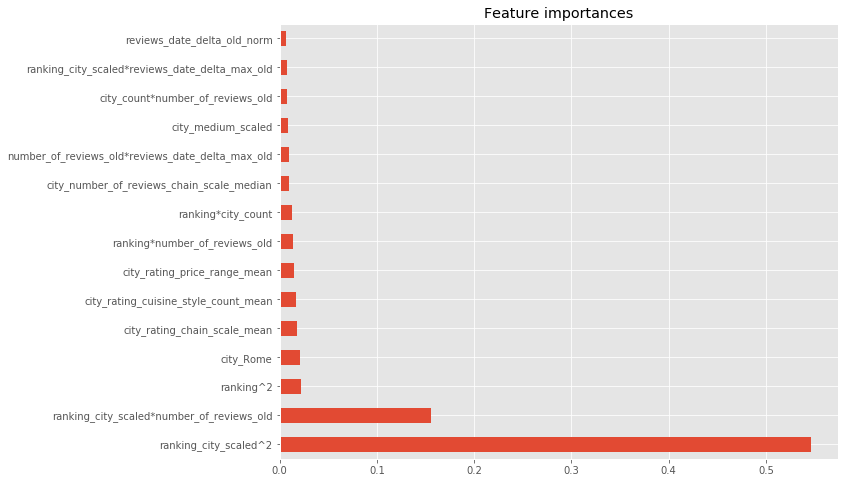

In [30]:
model, X, y = modelizer_round(data_num)
# y_pred_round_array: 0.1676875 (last time: 0.1699375)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)

[train] r2_score = 0.97 +/- 0.00
[valid] r2_score = 0.80 +/- 0.00


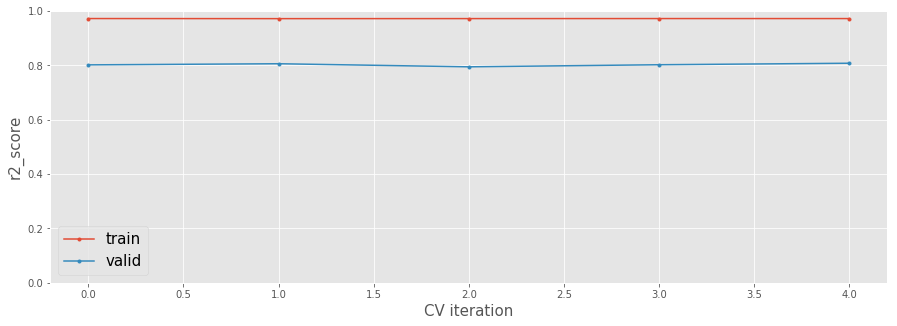

In [31]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='r2', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

**Underfitting** — a problem in which the algorithm has not studied the data well enough and misses important dependencies between features. In the case of underfitting, we cannot even achieve acceptable estimates for the model based on training data.

Why can there be underfitting?
- Incorrectly selected learning algorithm
- Inadequate error function
- Hyperparameters are not configured or incorrectly configured

How to get rid of underfitting?
- Complication of the model
- Weakening of regularization parameters

In [32]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [33]:
import pickle

best_model = pickle.dumps(model)

with open('/kaggle/working/best_model.pkl', 'wb') as output:
       pickle.dump(best_model, output)